In [1]:
# Install the library into this environment if you haven't already
# !pip install daesim-preprocess

In [32]:
from DAESIM_preprocess.terrain_tiles import terrain_tiles
from DAESIM_preprocess.topography import topography

import numpy as np
import matplotlib.pyplot as plt

# import rasterio
# from rasterio.enums import Resampling
from matplotlib import colors
# import matplotlib.font_manager as fm
from matplotlib.font_manager import FontProperties
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

# Basic Example

In [3]:
# Example variables
lat = -34.3890427
lon=148.469499
buffer = 0.01  # Degrees in each direction (so ~2kmx2km)

outdir = 'outdir'
stub = 'TEST'
tmpdir = 'tmpdir'

import os
if not os.path.exists(outdir):
    os.mkdir(outdir)
if not os.path.exists(tmpdir):
    os.mkdir(tmpdir)

In [4]:
%%time
# Need to run terrain_tiles.py with the same stub before running topography.py
ds = terrain_tiles(lat, lon, buffer, outdir, stub, tmpdir)

Starting terrain_tiles.py
Downloaded tmpdir/TEST_terrain_original.tif
Saved outdir/TEST_terrain.tif
CPU times: user 404 ms, sys: 49.8 ms, total: 454 ms
Wall time: 839 ms


In [7]:
# The main function
ds = topography(outdir, stub)
ds

Starting topography.py
Loading the pre-downloaded terrain tif
Smoothing the terrain using a gaussian filter
Calculating accumulation
Calculating slope and TWI
Saving the tif files
Saved: outdir/TEST_accumulation.tif
Saved: outdir/TEST_aspect.tif
Saved: outdir/TEST_slope.tif
Saved: outdir/TEST_twi.tif


<xarray.Dataset> Size: 11MB
Dimensions:       (x: 466, y: 565)
Coordinates:
  * x             (x) float64 4kB 1.653e+07 1.653e+07 ... 1.653e+07 1.653e+07
  * y             (y) float64 5kB -4.08e+06 -4.08e+06 ... -4.083e+06 -4.083e+06
    spatial_ref   int64 8B 0
Data variables:
    terrain       (y, x) float64 2MB 531.0 531.0 530.0 ... 552.0 552.0 552.0
    dem_smooth    (y, x) float64 2MB 530.4 530.4 530.4 ... 551.0 551.0 551.0
    accumulation  (y, x) float64 2MB 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0 1.0
    aspect        (y, x) uint8 263kB 2 2 2 2 2 4 8 16 ... 32 32 32 32 32 32 64
    slope         (y, x) float64 2MB 0.1207 0.1411 0.1734 ... 0.4818 0.4279 0.41
    twi           (y, x) float64 2MB 6.162 6.007 5.801 5.82 ... 4.778 4.897 4.94

# Example visualisations
Also good to open the tif files in QGIS to check they are correctly geolocated.


outdir/TEST_topography.png


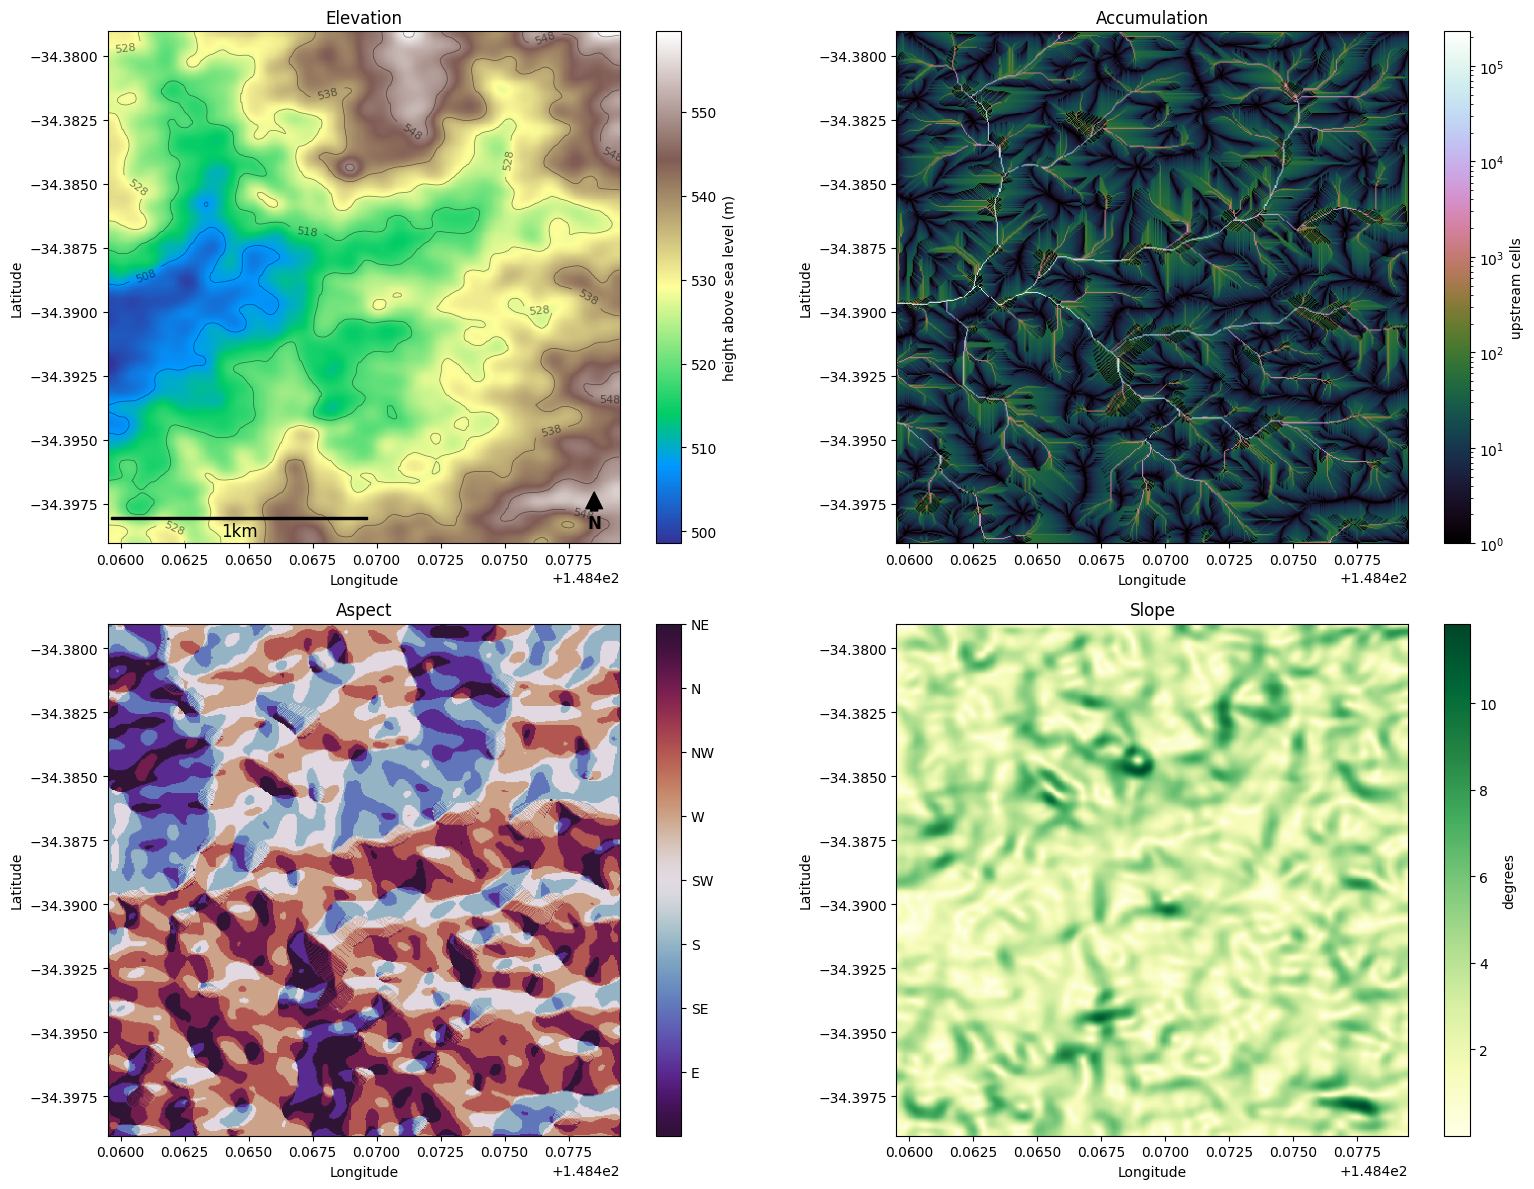

In [46]:
# Reproject to World Geodetic System
ds = ds.rio.reproject("EPSG:4326")
left, bottom, right, top = ds.rio.bounds()
extent = (left, right, bottom, top)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
(ax1, ax2), (ax3, ax4) = axes

# ===== Elevation Plot =====
dem = ds['dem_smooth']
im = ax1.imshow(dem, cmap='terrain', interpolation='bilinear', extent=extent)
ax1.set_title("Elevation")
plt.colorbar(im, ax=ax1, label='height above sea level (m)')

# Contours
interval = 10
contour_levels = np.arange(np.floor(np.nanmin(dem)), np.ceil(np.nanmax(dem)), interval)
contours = ax1.contour(dem, levels=contour_levels, colors='black',
                       linewidths=0.5, alpha=0.5, extent=extent, origin='upper')
ax1.clabel(contours, inline=True, fontsize=8, fmt='%1.0f')

# Scale bar
scalebar = AnchoredSizeBar(ax1.transData, 0.01, '1km', loc='lower left', pad=0.1,
                           color='black', frameon=False, size_vertical=0.0001,
                           fontproperties=FontProperties(size=12))
ax1.add_artist(scalebar)

# North arrow
ax1.annotate('N',
             xy=(0.95, 0.1), xycoords='axes fraction',   # Arrow tip (higher position)
             xytext=(0.95, 0.04),                         # Arrow base (lower position)
             arrowprops=dict(facecolor='black', width=5, headwidth=12),
             ha='center', va='center',
             fontsize=12, fontweight='bold', color='black')

# ===== Accumulation Plot =====
acc = ds['accumulation']
im = ax2.imshow(acc, cmap='cubehelix', norm=colors.LogNorm(1, np.nanmax(acc)),
                interpolation='bilinear', extent=extent)
ax2.set_title("Accumulation")
plt.colorbar(im, ax=ax2, label='upstream cells')

# ===== Aspect Plot =====
arcgis_dirs = np.array([1, 2, 4, 8, 16, 32, 64, 128]) 
sequential_dirs = np.array([1, 2, 3, 4, 5, 6, 7, 8]) 
fdir = ds['aspect']
fdir_equal_spacing = np.zeros_like(fdir)  
for arcgis_dir, sequential_dir in zip(arcgis_dirs, sequential_dirs):
    fdir_equal_spacing[fdir == arcgis_dir] = sequential_dir 

im = ax3.imshow(fdir_equal_spacing, cmap="twilight_shifted", origin="upper", extent=extent)
ax3.set_title("Aspect")
cbar = plt.colorbar(im, ax=ax3)
cbar.set_ticks(sequential_dirs)
cbar.set_ticklabels(["E", "SE", "S", "SW", "W", 'NW', "N", "NE"])

# ===== Slope Plot =====
slope = ds['slope']
im = ax4.imshow(slope, cmap="YlGn", origin="upper", extent=extent)
ax4.set_title("Slope")
cbar = plt.colorbar(im, ax=ax4)
cbar.set_label("degrees")

# Add lat/lon labels
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlabel("Longitude")
    ax.set_ylabel("Latitude")

# Save combined figure
plt.tight_layout()
filepath = os.path.join(outdir, stub + "_topography.png")
plt.savefig(filepath, dpi=300)
print(filepath)